In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import pandas_datareader.data as web
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = 'C:/Windows/Fonts/NGULIM.TTF'
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family=font)


In [2]:
import yfinance as yf
tsla = yf.Ticker('TSLA')

In [3]:
data = yf.download("TSLA", start="2020-01-01", end="2023-06-30")

[*********************100%***********************]  1 of 1 completed


In [4]:
data = data.reset_index()[['Date','Close']]
data

,Date,Close
0,2020-01-02,28.684000
1,2020-01-03,29.534000
2,2020-01-06,30.102667
3,2020-01-07,31.270666
4,2020-01-08,32.809334
...,...,...
874,2023-06-23,256.600006
875,2023-06-26,241.050003
876,2023-06-27,250.210007
877,2023-06-28,256.239990


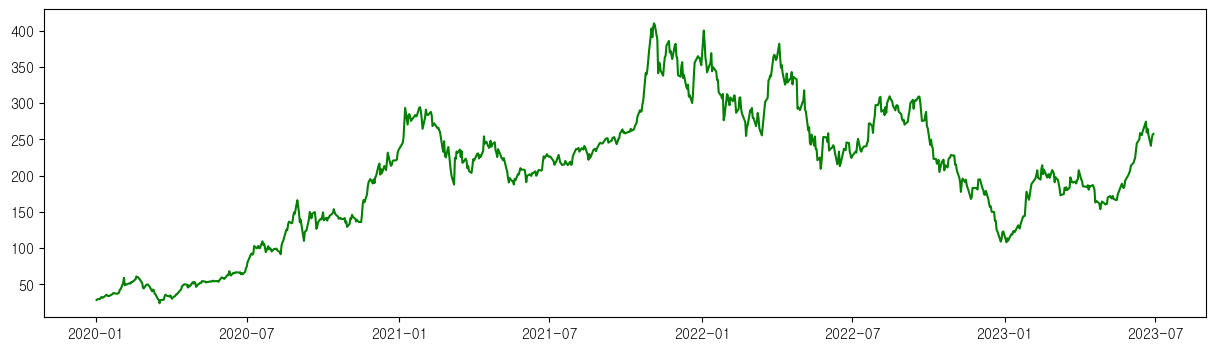

In [5]:
plt.figure(figsize=(15, 4))
    
plt.plot(data['Date'], data['Close'], color=  'g', label = 'Original')

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device} is available.')

cuda is available.


In [7]:
base_config = {
    'batch_size': 32, # 일반적으로 32, 64 크기의 mini-batch가 성능에는 가장 좋다고 알려져 있다.
    'epoch': 800, # 
    'learning_rate' : 0.00005,
    'seq_len': 90, # look_back_window_size
    # 'label_len':2, # 이건 뭘까
    'pred_len': 30, 
    'individual' : True,
    'enc_in':0 # feature column 개수
}

In [8]:
# torch를 사용할 때 seed 고정
def seed_everything(seed: int = 311):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) # type: ignore
    torch.backends.cudnn.deterministic = True # type : ignore
    torch.backends.cudnn.benchmark = True # type : ignore


seed_everything()

In [9]:
class moving_avg(nn.Module):
    '''
    Moving average block to highlight the trend of time series
    '''
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size = kernel_size, stride = stride, padding = 0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size -1) //2, 1)

        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1)) 
        x = x.permute(0,2,1) # 차원 순서바꾸기
        return x
    

# decomposition하여 res, trend 만드는 클래스
class series_decomp(nn.Module):
    '''
    Series decomposition block
    '''
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        
        return res, moving_mean
    


class DLinear(nn.Module):
    """
    DLinear model
    """
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs['seq_len']
        self.pred_len = configs['pred_len']

        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size) # 리턴값이 두개인데..
        self.individual = configs['individual'] # individual
        self.channels = configs['enc_in'] 
        # self.channels =1 

        

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList() # 리스트 초기화 선언 같은거
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels): # feature_size 만큼 -> 컬럼 개수만큼
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len, self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)
            


        # multivariable을 하나의 output으로 내주기 위해
        # self.Linear_Decoder = nn.Linear(self.channels, 1) #  ex) 4개 -> 1개

        
        


    def forward(self, x):
        # x: [Batch, Input, Length, Channel]
        seasonal_init, trend_init = self.decomposition(x)
        seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual: # channel 마다 도니까 torch.zeros로 초기화해주는 것 같다.
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len], dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len], dtype=trend_init.dtype).to(trend_init.device)
            
            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)
            
        #######
        
        x= seasonal_output + trend_output # [Batch, Channel, output length] == [32, 4, 12]
        
        
        
        
        x = x.permute(0,2,1) # to [Batch, Output length, Channel] == [32, 12, 4]
        # result = self.Linear_Decoder(x)


        # 원하는 output 양식 == [32, 12, 1]

      
        
        return x

In [10]:
# sliding window -> 이부분 수정해야할듯하다.
def time_slide_df(df, window_size, forcast_size, date, target):
    df_ = df.copy()
    # df_no_date = df_.drop([date], axis=1) # 날짜 지워주고
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size+1): # 0 ~ 
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)# 
        y = df_.loc[idx+window_size:idx+window_size+forcast_size-1, target].values # 여러개 예측 미래시점t0 ~ 미래시점t forecasting_size만큼)
        # date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        # y = df_.loc[idx:idx+window_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forcast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [11]:
# 스케일링 함수
def scaling_df(sample_data, scaler):
    df = sample_data.copy()
    date_info = df['PRSDT'].values
    # key_nm_ = df['primary_key'].iloc[0]


    # 타겟값은 로그스케일링
    target_log = np.log1p(df['FKIMG_SUM'].values)
    # df.drop(['PRSDT', 'primary_key', 'FKIMG_SUM'], axis=1, inplace=True)
    # df.drop(['PRSDT', 'primary_key'], axis=1, inplace=True)
    # x_col_lst = df.columns

    
    # x_col은 min_max_scaling
    # scaler = MinMaxScaler()
    # scaled_ = scaler.fit_transform(df)
    scaled_df = pd.DataFrame({'PRSDT':date_info, 'FKIMG_SUM':target_log})

    # scaled_df['PRSDT'] = date_info
    # scaled_df['FKIMG_SUM'] = target_log

    
    return scaled_df 

In [23]:
config = base_config.copy()
window_size = config['seq_len'] # 
forcast_size = config['pred_len'] # 
batch_size = config['batch_size'] # 
config['enc_in'] = len(data.columns)-1
targets = 'Close'
date = 'Date'


pred_date = '2023-05-01' 

train_df = data[data['Date']<pred_date]
test_start_date = data[data['Date']< pred_date]['Date'].iloc[-90]
test_df = data[data['Date']>= test_start_date].head(120).reset_index(drop=True)


train_x, train_y, train_date = time_slide_df(train_df, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df, window_size, forcast_size, date, targets)



train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)

# DataLoader
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds,batch_size = test_x.shape[0], shuffle=False)


### 모델 학습 ###
train_loss_list = []
test_loss_list = []


epoch = config['epoch'] # 일단 
DLinear_model = DLinear(config)
criterion = nn.MSELoss()
# criterion = MeanAbsolutePercentageError()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=config['learning_rate'])
max_loss = 999999999



for epoch in tqdm(range(1, epoch+1)): # 
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data_, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data_)
        # output = output.mean(dim=2).reshape(output.shape[0], output.shape[1],1)
        
        # output = output.detach().cpu().numpy()
        # target = target.detach().cpu().numpy()

        loss = criterion(output, target.unsqueeze(-1))
        # loss = criterion(output.reshape(output.shape[0],output.shape[1],), target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval() # 검증모드
    with torch.no_grad(): # autograd engine 끄기, 더이상 자동으로 gradient를 트래킹하지 않음.
                            # loss.backward()를 통해 backpropagation을 진행하지 않는다면 안써도 무방하겠지만 autograd를 끔으로써 메모리 사용량을 줄이고 연산속도를 높일 수 있다.
        for data_, target in test_dl:
            output = DLinear_model(data_)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)




    if loss < max_loss:
        torch.save(DLinear_model, f"./DLinear_model.pth")
        max_loss = loss
        # print("test_loss{:.3f}, Model Save".format(test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_test_loss = np.mean(test_loss.item())

    # if epoch % 100 ==0:
    #     print("epoch = {}, train_loss : {:.6f}, test_loss : {:.6f}".format(epoch, np.mean(loss_list),  test_loss))


print()

DLinear_model.eval() # 검증모드
with torch.no_grad(): # autograd engine 끄기, 더이상 자동으로 gradient를 트래킹하지 않음.
                            # loss.backward()를 통해 backpropagation을 진행하지 않는다면 안써도 무방하겠지만 autograd를 끔으로써 메모리 사용량을 줄이고 연산속도를 높일 수 있다.
        for data_, target in test_dl:
                output = DLinear_model(data_)

real_date = test_date[-1]
real_val = target.numpy()[-1].reshape(30,) # real값
pred_val = output.numpy()[-1].reshape(30,) # prediction 값

tmp_tmp_tmp = {'date':real_date, 'real':real_val, 'pred':pred_val}
# tmp_tmp_tmp = {'date':real_date, 'pred':pred_val}
prediction_df = pd.DataFrame(tmp_tmp_tmp)
prediction_df['date'] = pd.to_datetime(prediction_df['date'])


100%|██████████| 800/800 [00:26<00:00, 29.68it/s]

In [24]:
prediction_df

,date,real,pred
0,2023-05-01,161.830002,159.189209
1,2023-05-02,160.309998,159.617325
2,2023-05-03,160.610001,160.125000
3,2023-05-04,161.199997,157.912537
4,2023-05-05,170.059998,158.520187
5,2023-05-08,171.789993,156.658493
6,2023-05-09,169.149994,158.326447
7,2023-05-10,168.539993,156.881760
8,2023-05-11,172.080002,154.445160
9,2023-05-12,167.979996,158.647659


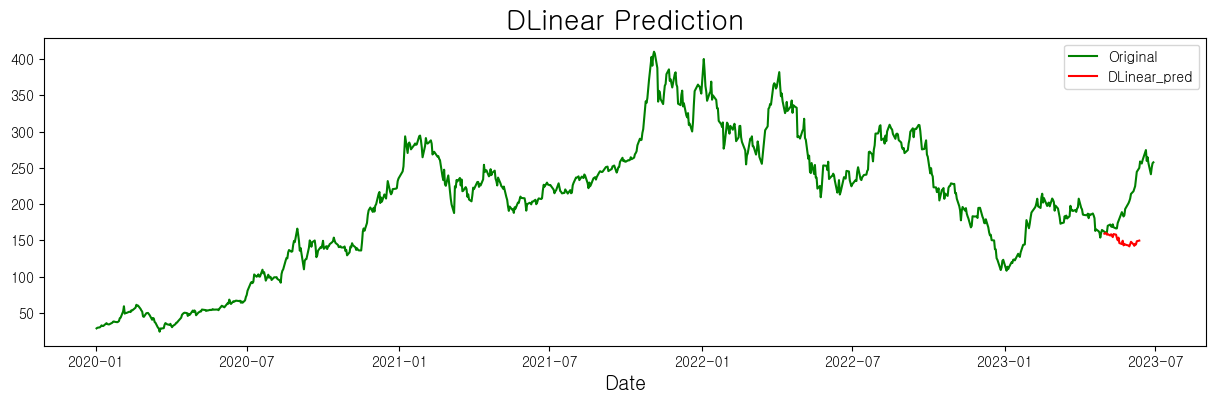

In [27]:
plt.figure(figsize=(15, 4))
plt.plot(data.Date, data.Close,  color='g', label = 'Original')


plt.plot(prediction_df.date, prediction_df.pred,  color='r', label = 'DLinear_pred')
plt.title(f'DLinear Prediction', fontsize=20) 
plt.xlabel('Date', fontsize=14)

plt.legend()